In [49]:
import numpy as np
import matplotlib.pyplot as plt

In [50]:
def Plot_curve(X,Y_arr,Y_legends,
                X_label,Y_label,
                marker_list,linestyle_list,
                dpi=150):
    #Plot parameters
    fonttype = "Helvetica"
    fontsize = 10
    grid_linewidth = 0.8
    plot_linewidth = 1.5
    colors_list = ['tab:blue', 'tab:orange', 'tab:red', 'tab:green']
    plt.figure(figsize=(10,8))
    for idx in range(np.shape(Y_arr)[1]):
        plt.plot(X,Y_arr[:,idx],label=Y_legends[idx],
                    color=colors_list[idx], marker=marker_list[idx],
                    linestyle=linestyle_list[idx], linewidth=plot_linewidth)

    plt.yticks(fontproperties = fonttype, size = fontsize)
    plt.xticks(fontproperties = fonttype, size = fontsize)
    plt.rcParams["font.family"] = fonttype
    plt.rcParams.update({'font.size': fontsize})
    plt.ylabel(Y_label, fontdict={'family' : fonttype, 'size' : fontsize})
    plt.xlabel(X_label, fontdict={'family' : fonttype, 'size' : fontsize})
    plt.legend()
    plt.grid(linewidth=grid_linewidth, alpha=0.3)
    savename = "results/"+str(Y_label)+".png"
    plt.savefig(savename,dpi=dpi)
    plt.tight_layout()
    plt.show()


In [54]:
wavl_vec = np.linspace(1.5,1.6,21).reshape(21,1)
filename_uncoupled = "results/beta_uncoupled.txt"
filename_coupled = "results/beta_coupled.txt"
beta_uncoupled_arr = []
with open(filename_uncoupled,'r') as f:
    data_uncoupled = f.readlines()
    for line in data_uncoupled:
        beta_uncoupled_arr.append(np.float64(line.split(",")))
beta_uncoupled_arr = np.array(beta_uncoupled_arr)
beta_uncoupled_arr = np.c_[wavl_vec,beta_uncoupled_arr]
beta_uncoupled_arr[:,:]

array([[ 1.5       , -0.62258898,  0.62258898],
       [ 1.505     , -0.55554619,  0.55554619],
       [ 1.51      , -0.49019782,  0.49019782],
       [ 1.515     , -0.42618638,  0.42618638],
       [ 1.52      , -0.36349777,  0.36349777],
       [ 1.525     , -0.302118  ,  0.302118  ],
       [ 1.53      , -0.24196582,  0.24196582],
       [ 1.535     , -0.1824616 ,  0.1824616 ],
       [ 1.54      , -0.12422755,  0.12422755],
       [ 1.545     , -0.06725028,  0.06725028],
       [ 1.55      , -0.01151652,  0.01151652],
       [ 1.555     ,  0.04298687, -0.04298687],
       [ 1.56      ,  0.09604792, -0.09604792],
       [ 1.565     ,  0.14775314, -0.14775314],
       [ 1.57      ,  0.19826495, -0.19826495],
       [ 1.575     ,  0.24759601, -0.24759601],
       [ 1.58      ,  0.29575886, -0.29575886],
       [ 1.585     ,  0.34276588, -0.34276588],
       [ 1.59      ,  0.38862934, -0.38862934],
       [ 1.595     ,  0.43336136, -0.43336136],
       [ 1.6       ,  0.47697394, -0.476

In [55]:
beta_coupled_arr = []
with open(filename_coupled,'r') as f:
    data_coupled = f.readlines()
    for line in data_coupled:
        line_float = np.float64(line.split(","))
        if line_float[0]<0:
            line_float = np.flip(line_float)
        beta_coupled_arr.append(line_float)
beta_coupled_arr = np.array(beta_coupled_arr)
beta_coupled_arr = np.c_[wavl_vec,beta_coupled_arr]
beta_coupled_arr[:,:]


array([[ 1.5       ,  0.62710927, -0.62710927],
       [ 1.505     ,  0.56032117, -0.56032117],
       [ 1.51      ,  0.4952434 , -0.4952434 ],
       [ 1.515     ,  0.43151783, -0.43151783],
       [ 1.52      ,  0.36913057, -0.36913057],
       [ 1.525     ,  0.30806789, -0.30806789],
       [ 1.53      ,  0.24824877, -0.24824877],
       [ 1.535     ,  0.18909317, -0.18909317],
       [ 1.54      ,  0.13122444, -0.13122444],
       [ 1.545     ,  0.07462961, -0.07462961],
       [ 1.55      ,  0.01929582, -0.01929582],
       [ 1.555     ,  0.05118416, -0.05118416],
       [ 1.56      ,  0.10468252, -0.10468252],
       [ 1.565     ,  0.15684469, -0.15684469],
       [ 1.57      ,  0.20783309, -0.20783309],
       [ 1.575     ,  0.25766092, -0.25766092],
       [ 1.58      ,  0.30634128, -0.30634128],
       [ 1.585     ,  0.35388715, -0.35388715],
       [ 1.59      ,  0.40031137, -0.40031137],
       [ 1.595     ,  0.44562669, -0.44562669],
       [ 1.6       ,  0.48984571, -0.489

In [56]:
beta_coupled_arr[:,1:] - beta_uncoupled_arr[:,1:]

array([[ 1.24969825, -1.24969825],
       [ 1.11586736, -1.11586736],
       [ 0.98544122, -0.98544122],
       [ 0.85770421, -0.85770421],
       [ 0.73262834, -0.73262834],
       [ 0.61018589, -0.61018589],
       [ 0.49021459, -0.49021459],
       [ 0.37155476, -0.37155476],
       [ 0.255452  , -0.255452  ],
       [ 0.14187989, -0.14187989],
       [ 0.03081234, -0.03081234],
       [ 0.00819729, -0.00819729],
       [ 0.0086346 , -0.0086346 ],
       [ 0.00909155, -0.00909155],
       [ 0.00956814, -0.00956814],
       [ 0.01006491, -0.01006491],
       [ 0.01058242, -0.01058242],
       [ 0.01112127, -0.01112127],
       [ 0.01168203, -0.01168203],
       [ 0.01226533, -0.01226533],
       [ 0.01287178, -0.01287178]])

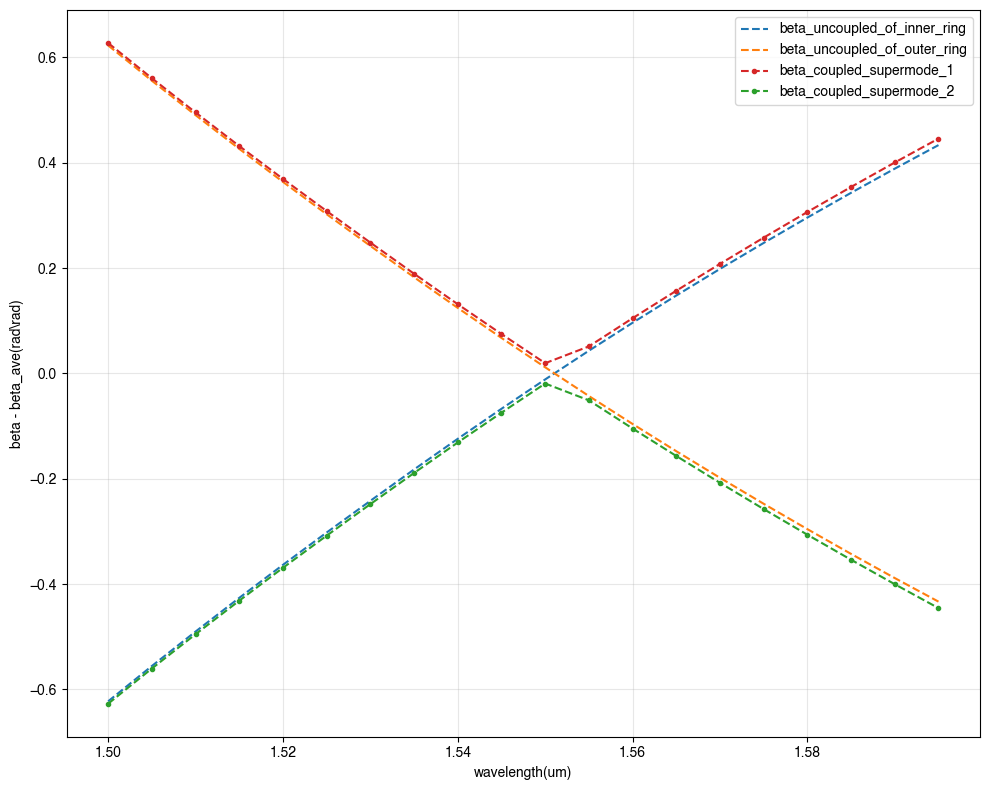

In [53]:
start_idx = 0
end_idx = -1
beta_uncoupled_arr = beta_uncoupled_arr[start_idx:end_idx,:]
beta_coupled_arr = beta_coupled_arr[start_idx:end_idx,:]
Y_data = np.c_[beta_uncoupled_arr[:,1:],beta_coupled_arr[:,1:]]
Plot_curve(beta_uncoupled_arr[:,0],Y_data,
           Y_legends=['beta_uncoupled_of_inner_ring','beta_uncoupled_of_outer_ring',
            'beta_coupled_supermode_1','beta_coupled_supermode_2'],
            X_label='wavelength(um)',Y_label='beta - beta_ave(rad\\rad)',
            marker_list=["","",".","."],linestyle_list=["--","--","--","--"]
           )